# Linear Regression, KNN, LGBM, XGB, Random Forest, SVR/Linear-SVR  - <br /> by Jerome, 03 December2021 #

---

In [1]:
## load modules
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modeling.functions import modelling, log_to_mlflow, get_features, baseline, modelling_fc 
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import seaborn as sns
import pickle 


RSEED = 42


/Users/jeromesauer/neuefische/Capstone_WindPowerPredicting/.venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Read data, remove NaNs and get dummies for cardinal wind directions ###

In [2]:
## read data
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', parse_dates=['TIMESTAMP'])
data.dropna(inplace=True)
data = pd.get_dummies(data, columns = ['WD100CARD','WD10CARD'], drop_first=True)
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 175265 entries, 0 to 175433
Data columns (total 47 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ZONEID         175265 non-null  int64         
 1   TIMESTAMP      175265 non-null  datetime64[ns]
 2   TARGETVAR      175265 non-null  float64       
 3   U10            175265 non-null  float64       
 4   V10            175265 non-null  float64       
 5   U100           175265 non-null  float64       
 6   V100           175265 non-null  float64       
 7   HOUR           175265 non-null  int64         
 8   MONTH          175265 non-null  int64         
 9   WEEKDAY        175265 non-null  int64         
 10  IS_HOLIDAY     175265 non-null  int64         
 11  WS10           175265 non-null  float64       
 12  WS100          175265 non-null  float64       
 13  WD10           175265 non-null  float64       
 14  WD100          175265 non-null  float64       
 15  

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,...,WD10CARD_NNW,WD10CARD_NW,WD10CARD_S,WD10CARD_SE,WD10CARD_SSE,WD10CARD_SSW,WD10CARD_SW,WD10CARD_W,WD10CARD_WNW,WD10CARD_WSW
0,1,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,1,6,...,0,1,0,0,0,0,0,0,0,0
1,1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761,2,1,6,...,0,1,0,0,0,0,0,0,0,0
2,1,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093,3,1,6,...,0,0,0,0,0,0,0,0,1,0
3,1,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546,4,1,6,...,0,0,0,0,0,0,0,1,0,0
4,1,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701,5,1,6,...,0,0,0,0,0,0,0,1,0,0


### Train-test-split, get different combinations of features and run different models with them ###

In [3]:
## train-test-split and get features and zones
data_train = data[data.TIMESTAMP <= pd.to_datetime('2013-07-01 00:00:00')]
data_test = data[data.TIMESTAMP > pd.to_datetime('2013-07-01 00:00:00')]
feature_dict = get_features(data)
zones = np.unique(data.ZONEID)

In [4]:
train, test, model_dict, cv = modelling(data_train, data_test, feature_dict['all'], LinearRegression(), scaler=None, print_scores=True, log=None, \
                infotext_mlflow=None, save_model = True, perform_gridCV = False, param_grid = None, \
                zone_params = None, n_jobs = -1)

train-RMSE/test-RMSE LinearRegression for ZONE1: 0.179 0.191

train-RMSE/test-RMSE LinearRegression for ZONE2: 0.144 0.176

train-RMSE/test-RMSE LinearRegression for ZONE3: 0.152 0.156

train-RMSE/test-RMSE LinearRegression for ZONE4: 0.177 0.176

train-RMSE/test-RMSE LinearRegression for ZONE5: 0.179 0.179

train-RMSE/test-RMSE LinearRegression for ZONE6: 0.181 0.194

train-RMSE/test-RMSE LinearRegression for ZONE7: 0.135 0.152

train-RMSE/test-RMSE LinearRegression for ZONE8: 0.161 0.198

train-RMSE/test-RMSE LinearRegression for ZONE9: 0.165 0.165

train-RMSE/test-RMSE LinearRegression for ZONE10: 0.199 0.211

train-RMSE/test-RMSE LinearRegression for TOTAL: 0.168 0.181



In [8]:
df1 = modelling_fc(data_train, data_test, feature_dict, LinearRegression(), scaler=None, print_scores=True, log=None, \
                  infotext_mlflow=None, save_model = True, perform_gridCV = False, param_grid = None, \
                  zone_params = None, n_jobs = -1)

# df2 = modelling_fc(data_train, data_test, feature_dict, \
#                   RandomForestRegressor(max_depth=10, n_estimators=100, min_samples_leaf=6, n_jobs=-1, random_state=RSEED), \
#                   scaler=None, print_scores=True, log=None, \
#                   infotext_mlflow=None, save_model = True, perform_gridCV = False, param_grid = None, \
#                   zone_params = None, n_jobs = -1)

# train, test, model_dict = modelling(data_train, data_test, feature_dict['all'], \
#                  LinearRegression(), \
#                   scaler=None, print_scores=True, log=None, \
#                   infotext_mlflow=None, save_model = True, perform_gridCV = False, param_grid = None, \
#                   zone_params = None, n_jobs = -1)


train-RMSE/test-RMSE LinearRegression for ZONE1: 0.179 0.191

train-RMSE/test-RMSE LinearRegression for ZONE2: 0.144 0.176

train-RMSE/test-RMSE LinearRegression for ZONE3: 0.152 0.156

train-RMSE/test-RMSE LinearRegression for ZONE4: 0.177 0.176

train-RMSE/test-RMSE LinearRegression for ZONE5: 0.179 0.179

train-RMSE/test-RMSE LinearRegression for ZONE6: 0.181 0.194

train-RMSE/test-RMSE LinearRegression for ZONE7: 0.135 0.152

train-RMSE/test-RMSE LinearRegression for ZONE8: 0.161 0.198

train-RMSE/test-RMSE LinearRegression for ZONE9: 0.165 0.165

train-RMSE/test-RMSE LinearRegression for ZONE10: 0.199 0.211

train-RMSE/test-RMSE LinearRegression for TOTAL: 0.168 0.181

train-RMSE/test-RMSE LinearRegression for ZONE1: 0.179 0.191

train-RMSE/test-RMSE LinearRegression for ZONE2: 0.144 0.176

train-RMSE/test-RMSE LinearRegression for ZONE3: 0.152 0.156

train-RMSE/test-RMSE LinearRegression for ZONE4: 0.177 0.176

train-RMSE/test-RMSE LinearRegression for ZONE5: 0.179 0.179

train-R

In [11]:
# ## run different models and save train/test-scores in scores

# # models list and option to save scores 
# #models = [('Baseline',True), ('LSVR',True), ('SVR',True), ('LR',True), 
# #          ('XGB',True), ('RF',True), ('LGBM',True)]
# models = [('', False)]

# # loop over different models and over various combinations of features
# for model,save in models:

#     # initialize scores dataframe 
#     scores = pd.DataFrame(columns = ['model', 'features', 'zone', 'train_score', 'test_score', 'bestparams'])
   
#     for fc in list(feature_dict.keys()): 

#         print(f'feature combination: {fc}\n')

#         # linear regression
#         if model == 'LR':
#             train, test = modelling(data_train, data_test, feature_dict[fc], LinearRegression())
#             scores = scores.append(dict_to_df(train, test, model, fc), ignore_index=True)

#         # KNN
#         if model == 'KNN': 
#             param_grid = {'n_neighbors' : np.arange(20,141,5), 'weights' : ['uniform','distance'], 'p' : [1,2]}
#             train, test, bestparams = \
#                 modelling(data_train, data_test, feature_dict[fc], KNeighborsRegressor(), \
#                           scaler=MinMaxScaler(), save_model = True, perform_gridCV = True, param_grid = param_grid)
#             scores = scores.append(dict_to_df(train, test, model, fc, z=bestparams), ignore_index=True)

#         # LGBM
#         if model == 'LGBM':
#             train, test = \
#                 modelling(data_train, data_test, feature_dict[fc], LGBMRegressor(random_state=RSEED))
#             scores = scores.append(dict_to_df(train, test, model, fc), ignore_index=True)
            
#         # RandomForest
#         if model == 'RF':
#             param_grid = {'n_estimators' : [100], 'max_depth' : np.arange(5,21,5), 'min_samples_leaf' : np.arange(5,21,5)}
#             #regressor = RandomForestRegressor(max_depth=10, n_estimators=100, min_samples_leaf=6, n_jobs=-1, random_state=RSEED)
#             regressor = RandomForestRegressor(random_state=RSEED, n_jobs=-1)
#             train, test, bestparams = \
#                 modelling(data_train, data_test, feature_dict[fc], regressor, save_model=save, perform_gridCV = True, param_grid = param_grid)
#             scores = scores.append(dict_to_df(train, test, model, fc, z=bestparams), ignore_index=True)
            
#         # XGBoost
#         if model == 'XGB':
#             train, test = \
#                 modelling(data_train, data_test, feature_dict[fc], XGBRegressor(random_state=RSEED))
#             scores = scores.append(dict_to_df(train, test, model, fc), ignore_index=True)
           
#     # LSVR and SVR - here data already prepared by Moritz and thus no need to loop over feature combinations
#     if model == 'LSVR':
#         temp = pd.read_csv('../data/GEFCom2014Data/Wind/211203_1152_LinearSVR.csv')
#         temp['model'] = 'LSVR'
#         temp['bestparams'] = np.nan
#         scores = scores.append(temp, ignore_index=True)

#     if model == 'SVR':
#         temp = pd.read_csv('../data/GEFCom2014Data/Wind/211203_1658_SVR.csv')
#         temp['model'] = 'SVR'
#         temp['bestparams'] = np.nan
#         scores = scores.append(temp, ignore_index=True)

#     # get Baseline model
#     if model == 'Baseline':
#         test = baseline(data_train, data_test)
#         test = pd.DataFrame.from_dict(test, orient='index', columns = ['test_score']).rename_axis('zone').reset_index()
#         test[['model','bestparams','train_score']] = ['Baseline',np.nan,np.nan]
#         scores = scores.append(test, ignore_index=True)
        
#     # save score dataframe and best parameters of one model in pickles
#     if save == True:
#         with open(f"../data/GEFCom2014Data/Wind/scores_{model}.pkl", "wb") as f_out:
#             pickle.dump(scores,f_out)

feature combination: all

feature combination: no_deg

feature combination: no_deg_norm

feature combination: no_deg_norm_U10V10

feature combination: no_deg_norm_WS10

feature combination: no_comp

feature combination: no_comp_plus_100Norm

feature combination: no_deg_comp

feature combination: no_ten

feature combination: no_card

feature combination: no_card_100Norm

feature combination: no_card_ten

feature combination: no_deg_comp_ten



In [12]:
# ## load pickles and save large pickle
# models = ['Baseline','LR','KNN','SVR','LSVR', 'LGBM', 'XGB', 'RF']
# scores = pd.DataFrame(columns = ['model', 'features', 'zone', 'train_score', 'test_score', 'bestparams'])

# for model in models:
#     with open(f"../data/GEFCom2014Data/Wind/scores_{model}.pkl", "rb") as f_in:
#         df = pickle.load(f_in)
#         #print(df.shape)
#     scores = scores.append(df, ignore_index=True)

# with open(f"../data/GEFCom2014Data/Wind/scores.pkl", "wb") as f_out:
#      pickle.dump(scores,f_out)




In [42]:
# scores[(scores.model=='RF') & (scores.zone=='TOTAL')].sort_values(by='test_score')
# rf = scores[(scores.model=='RF') & (scores.features=='no_comp_plus_100Norm')]
# rf.bestparams.values
# # a,b = rf.bestparams.values[0]['max_depth'], rf.bestparams.values[0]['min_samples_leaf']
# # a,b
# #hyper = [(a['max_depth'],b['min_samples_leaf']) for a,b in zip(rf.bestparams.values,rf.bestparams.values)]
# hyper = [(a['max_depth'],a['min_samples_leaf']) for a in rf.bestparams.values[:-1]]

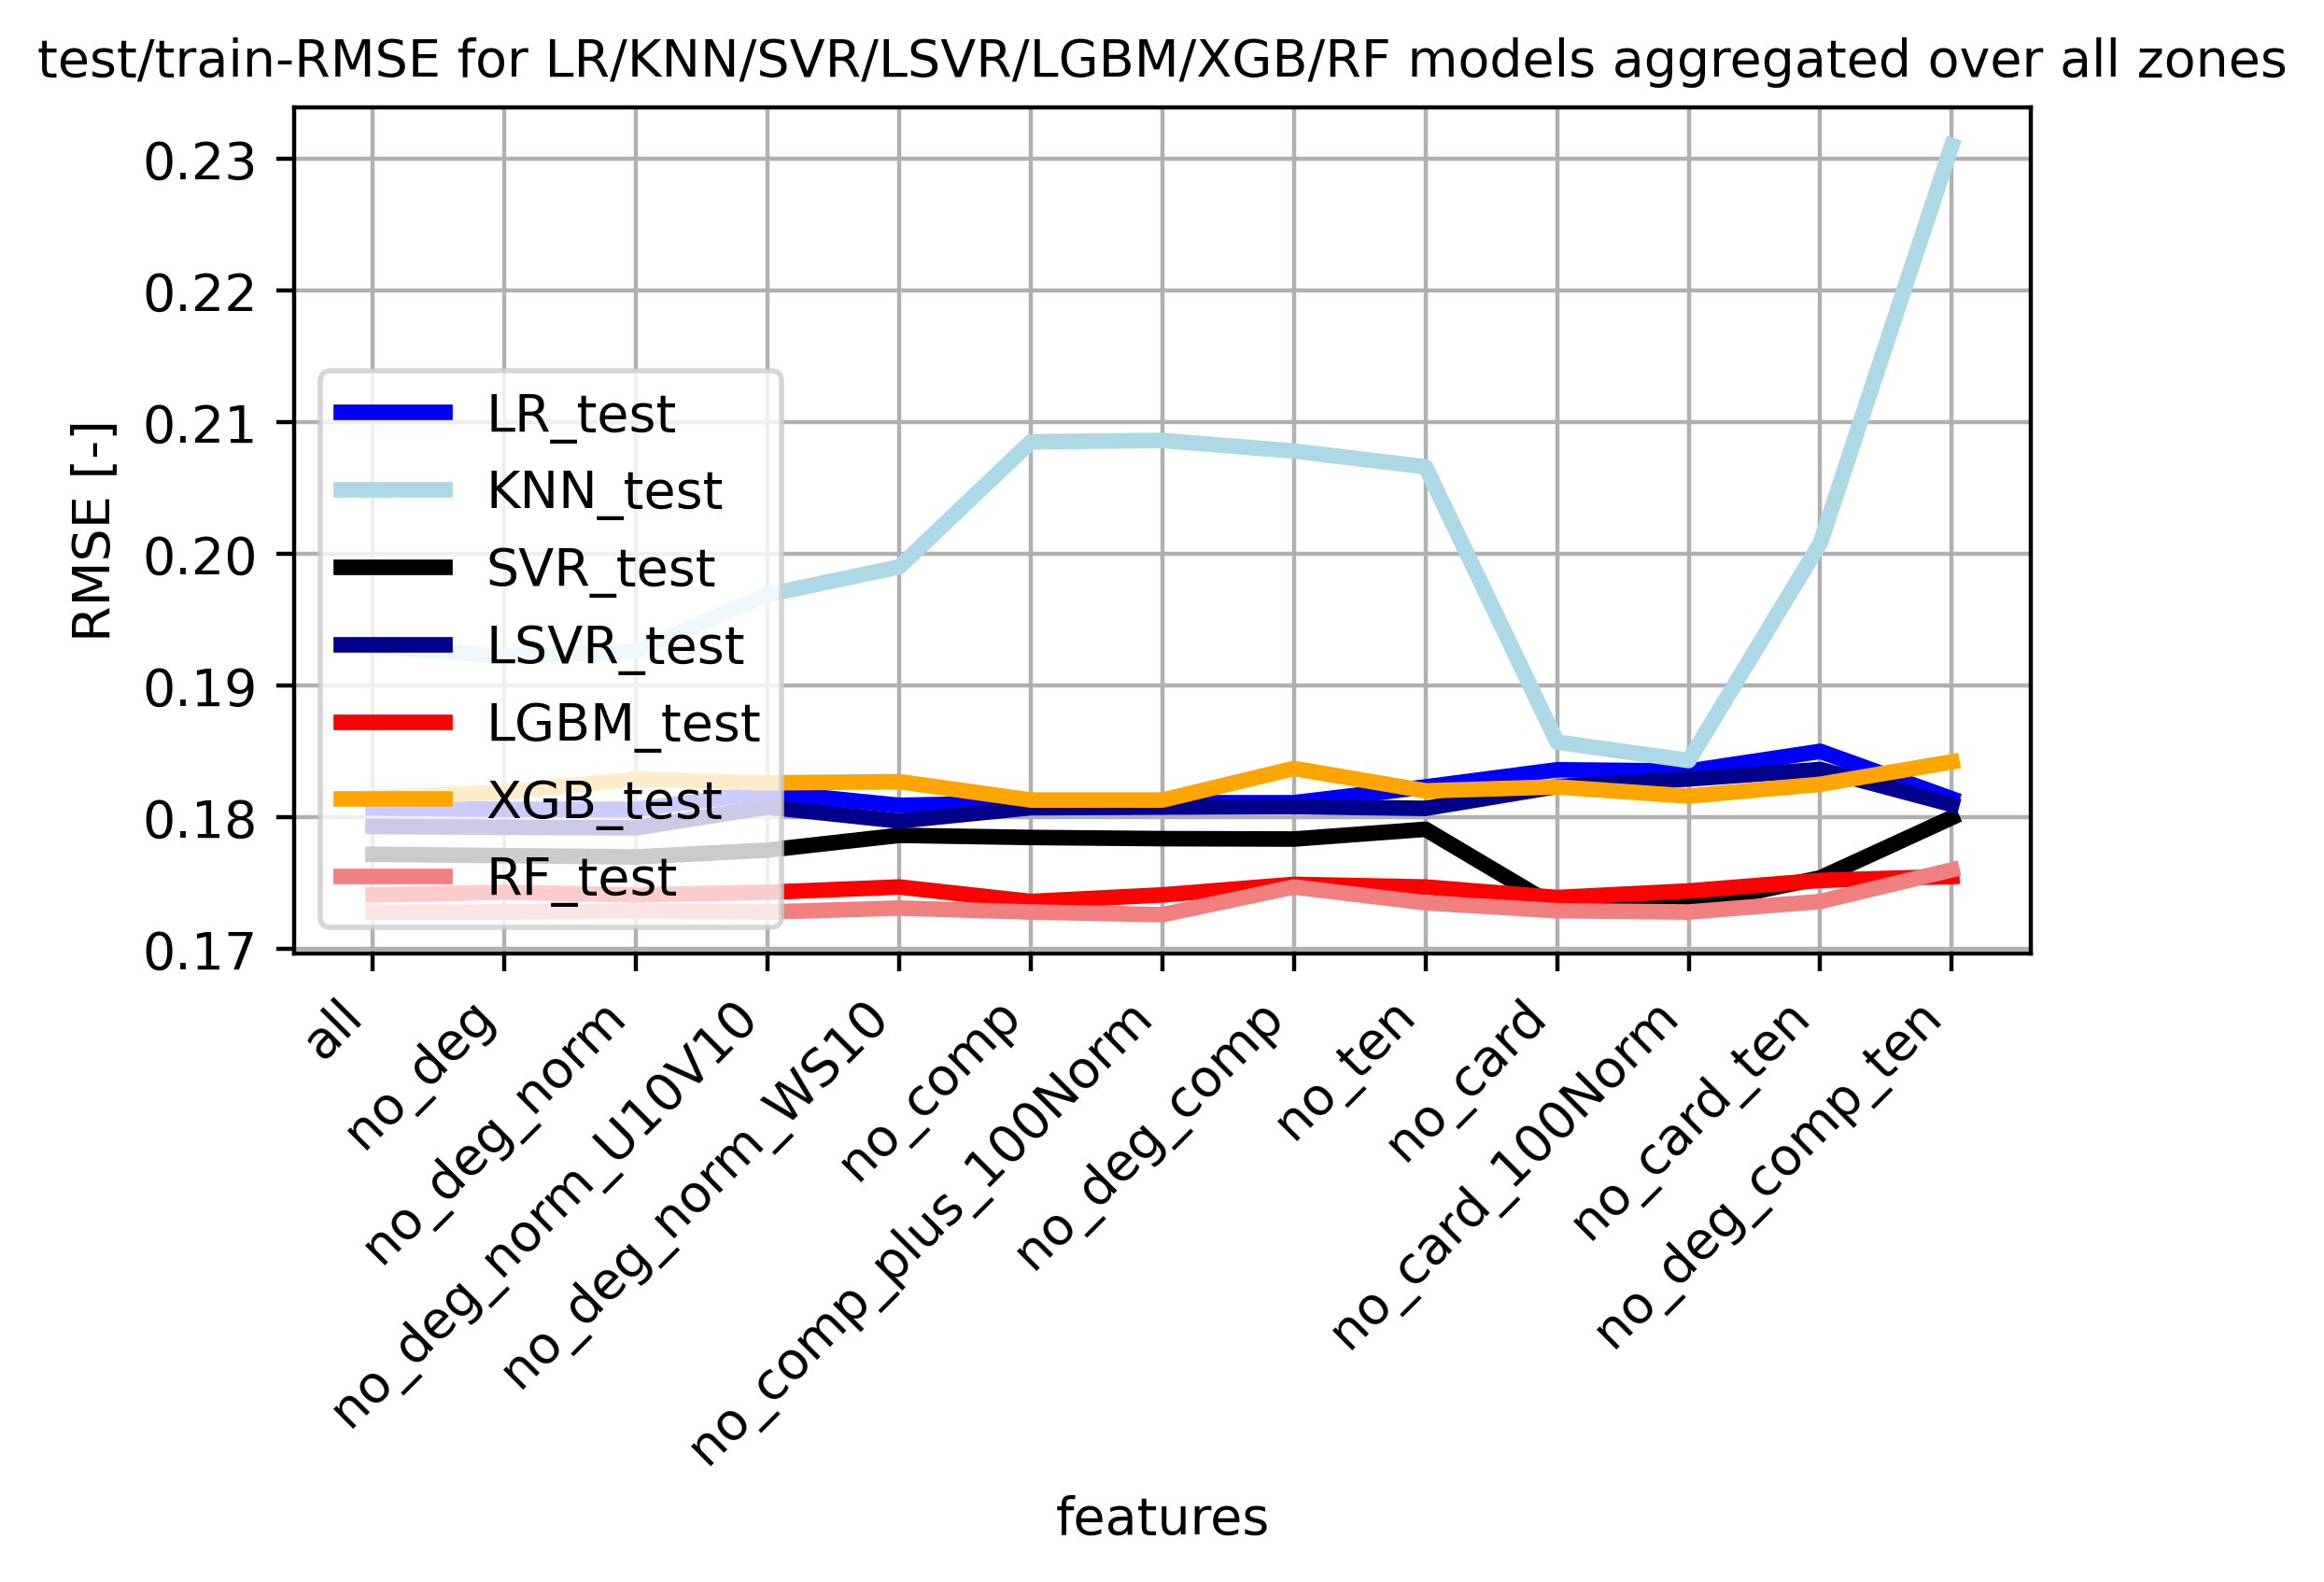

In [44]:
# ## plot zones-aggregated RMSE for different models against different feature combinations
# models = ['LR','KNN','SVR','LSVR', 'LGBM', 'XGB', 'RF']

# x = list(feature_dict.keys())
# linewidth, fontsize = 3, 10
# colors = ['b','lightblue','k','darkblue','r', 'orange', 'lightcoral']
# fig,ax = plt.subplots(figsize=(6,3), dpi=400)

# for i,model in enumerate(models):
#     ax.plot(x, scores[(scores.zone=='TOTAL') & (scores.model==model)].test_score, color=colors[i], linestyle='-', linewidth=linewidth)
#     #ax.plot(x, scores[(scores.zone=='TOTAL') & (scores.model==model)].train_score, color=colors[i], linestyle='--', linewidth=linewidth)

# plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
# ax.set_ylabel('RMSE [-]', fontsize = fontsize)
# ax.set_xlabel('features', fontsize = fontsize)
# ax.legend(['{}_{}'.format(model,tt) for model in models for tt in ['test']],loc='lower left')
# ax.grid()
# ax.set_title(f"test/train-RMSE for {'/'.join(models)} models aggregated over all zones", fontsize = fontsize);
# fig.savefig('../images/RMSE_features_TOTAL.png')

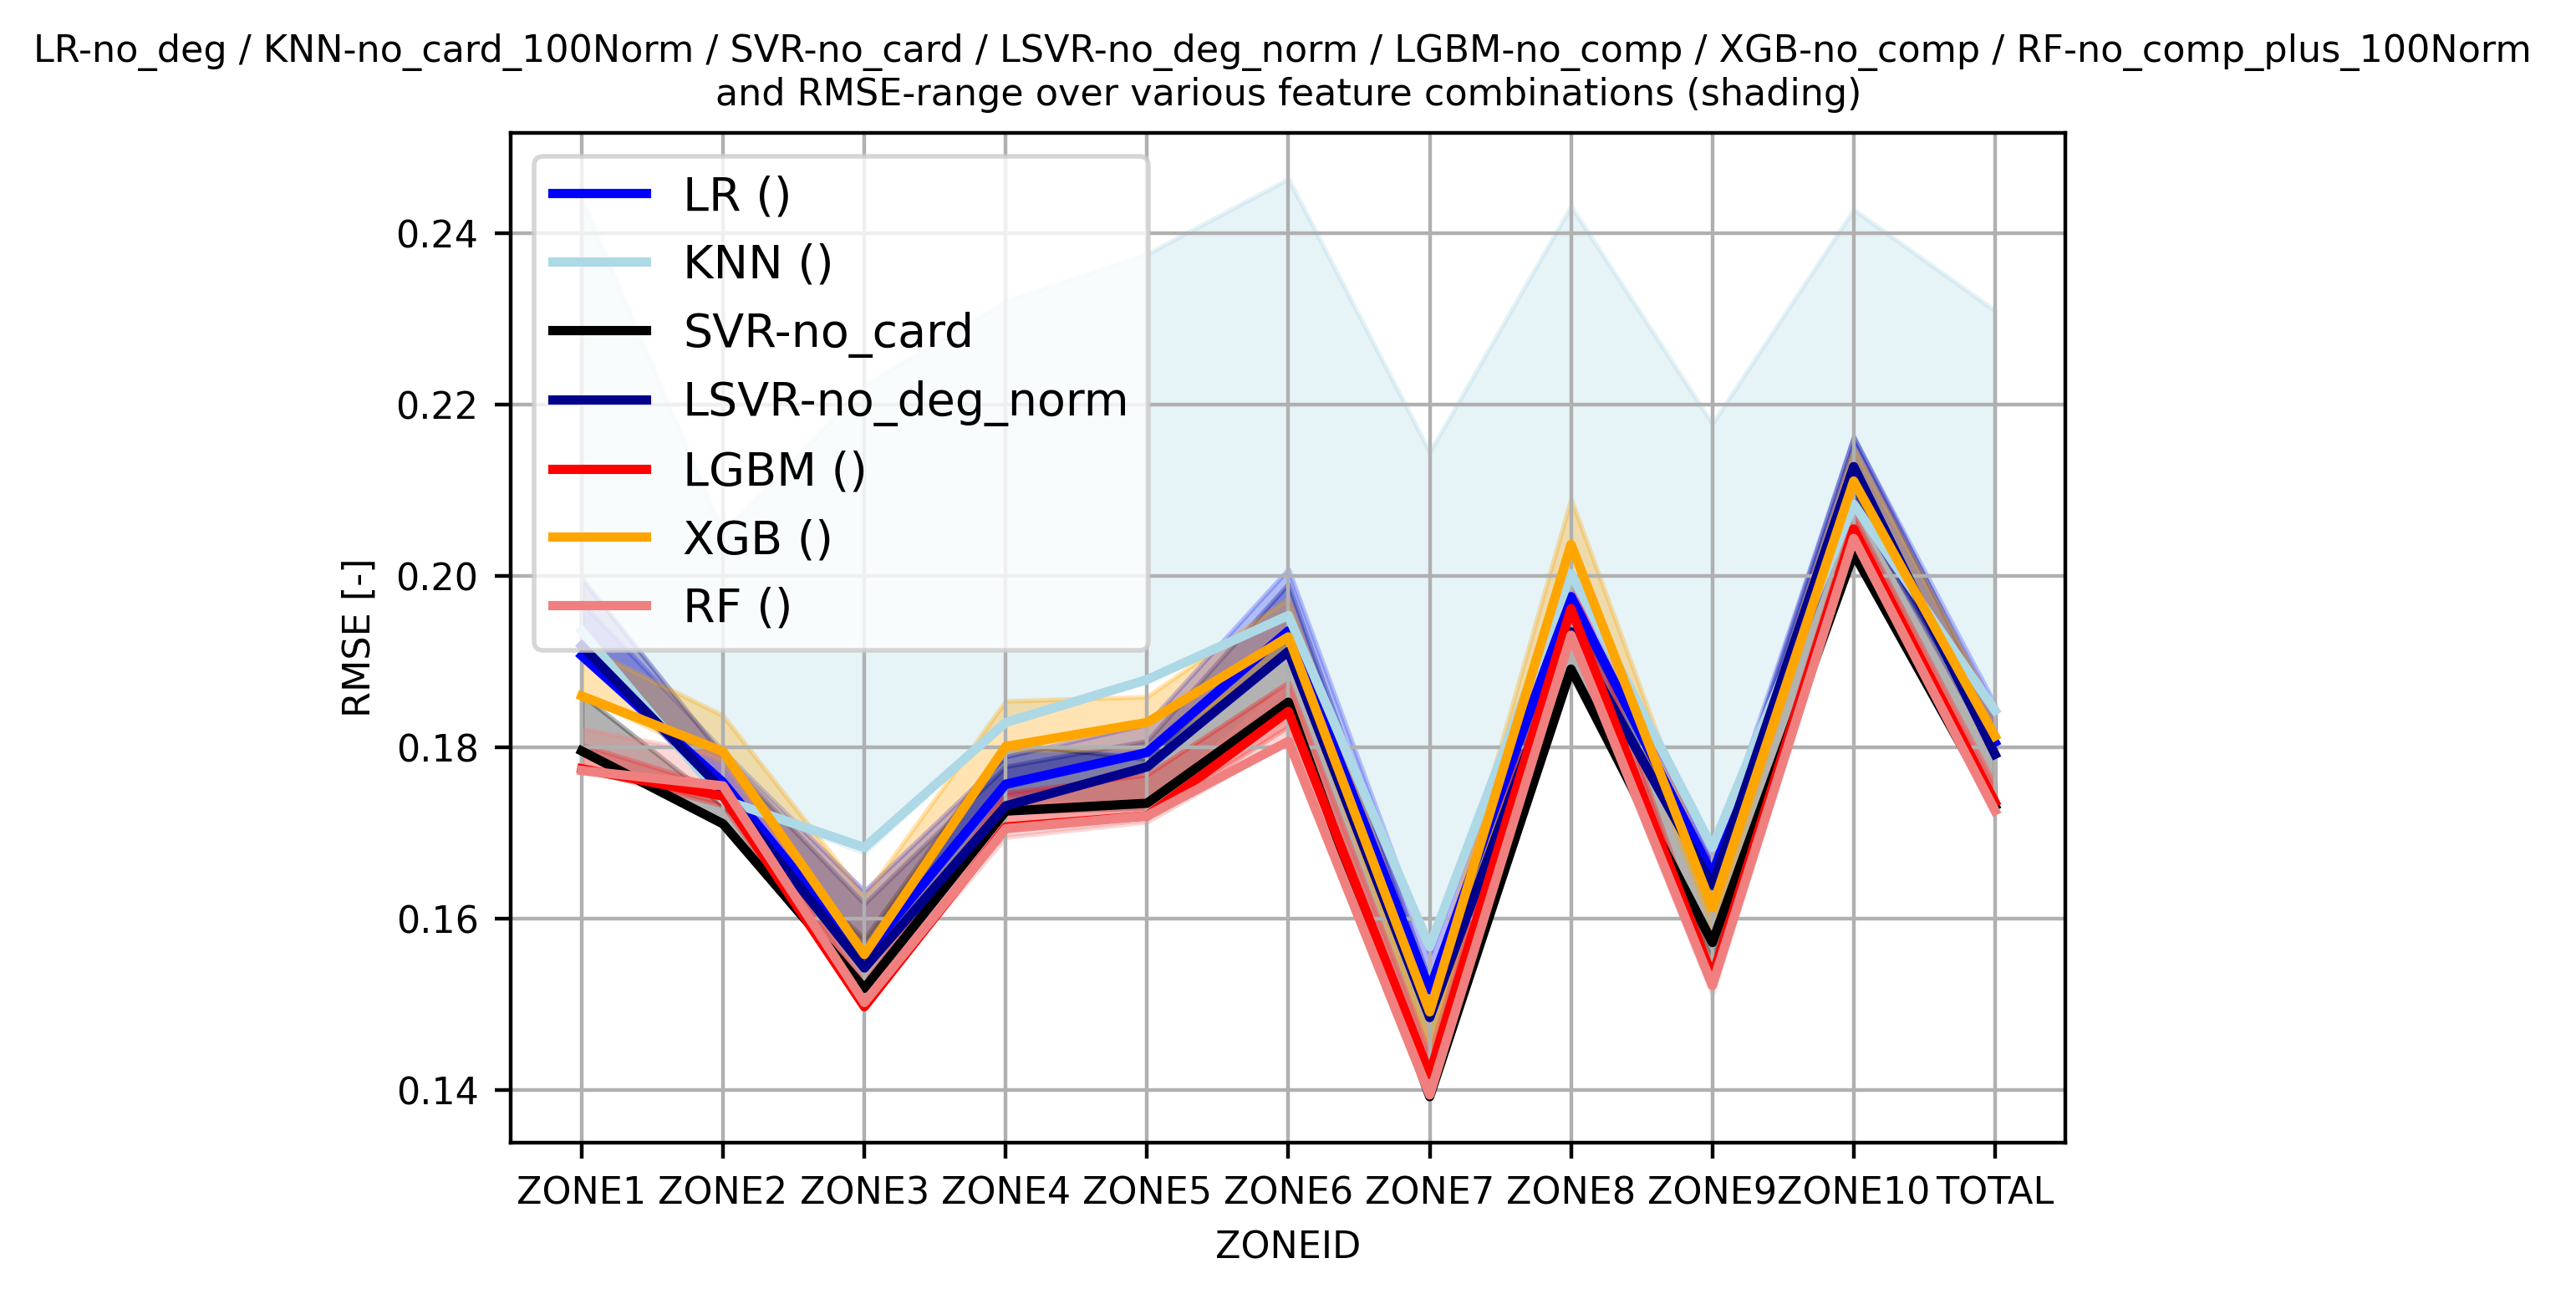

In [28]:
# ## plot test-RMSE for different models (best feature combination) against different zones and show RMSE-range over different feature combinations
# models = ['LR','KNN','SVR','LSVR', 'LGBM', 'XGB', 'RF']
# models = [(model, bestfeature(scores,model)) for model in models]

# linewidth, fontsize = 2, 8
# colors = ['b','lightblue','k','darkblue','r', 'orange', 'lightcoral']
# fig, ax = plt.subplots(dpi=400)

# for i,(model,fc) in enumerate(models):
    
#     y = scores[(scores.model==model) & (scores.features==fc)][['zone','test_score']].set_index('zone')
#     y = y.join(scores[scores.model==model].groupby(by='zone').max().test_score ,rsuffix='_max')   
#     y = y.join(scores[scores.model==model].groupby(by='zone').min().test_score ,rsuffix='_min') 

#     ax.plot(y.index, y.test_score, color=colors[i], linewidth=linewidth)
#     ax.fill_between(y.index, y.test_score_min, y.test_score_max, alpha=.3, color=colors[i])

# ax.grid()
# ax.tick_params(labelsize=fontsize)
# ax.set_ylabel('RMSE [-]', fontsize=fontsize)
# ax.set_xlabel('ZONEID', fontsize=fontsize)

# ax.legend(['{}-{}'.format(model,fc) if model in ('LSVR') else '{} ()'.format(model) for model,fc in models])
# ax.set_title('{} {}'.format(' / '.join(['{}-{}'.format(model,fc) for model,fc in models]),\
#                             '\nand RMSE-range over various feature combinations (shading)'), fontsize=fontsize);

# fig.savefig('../images/RMSE_ZONEID.png')

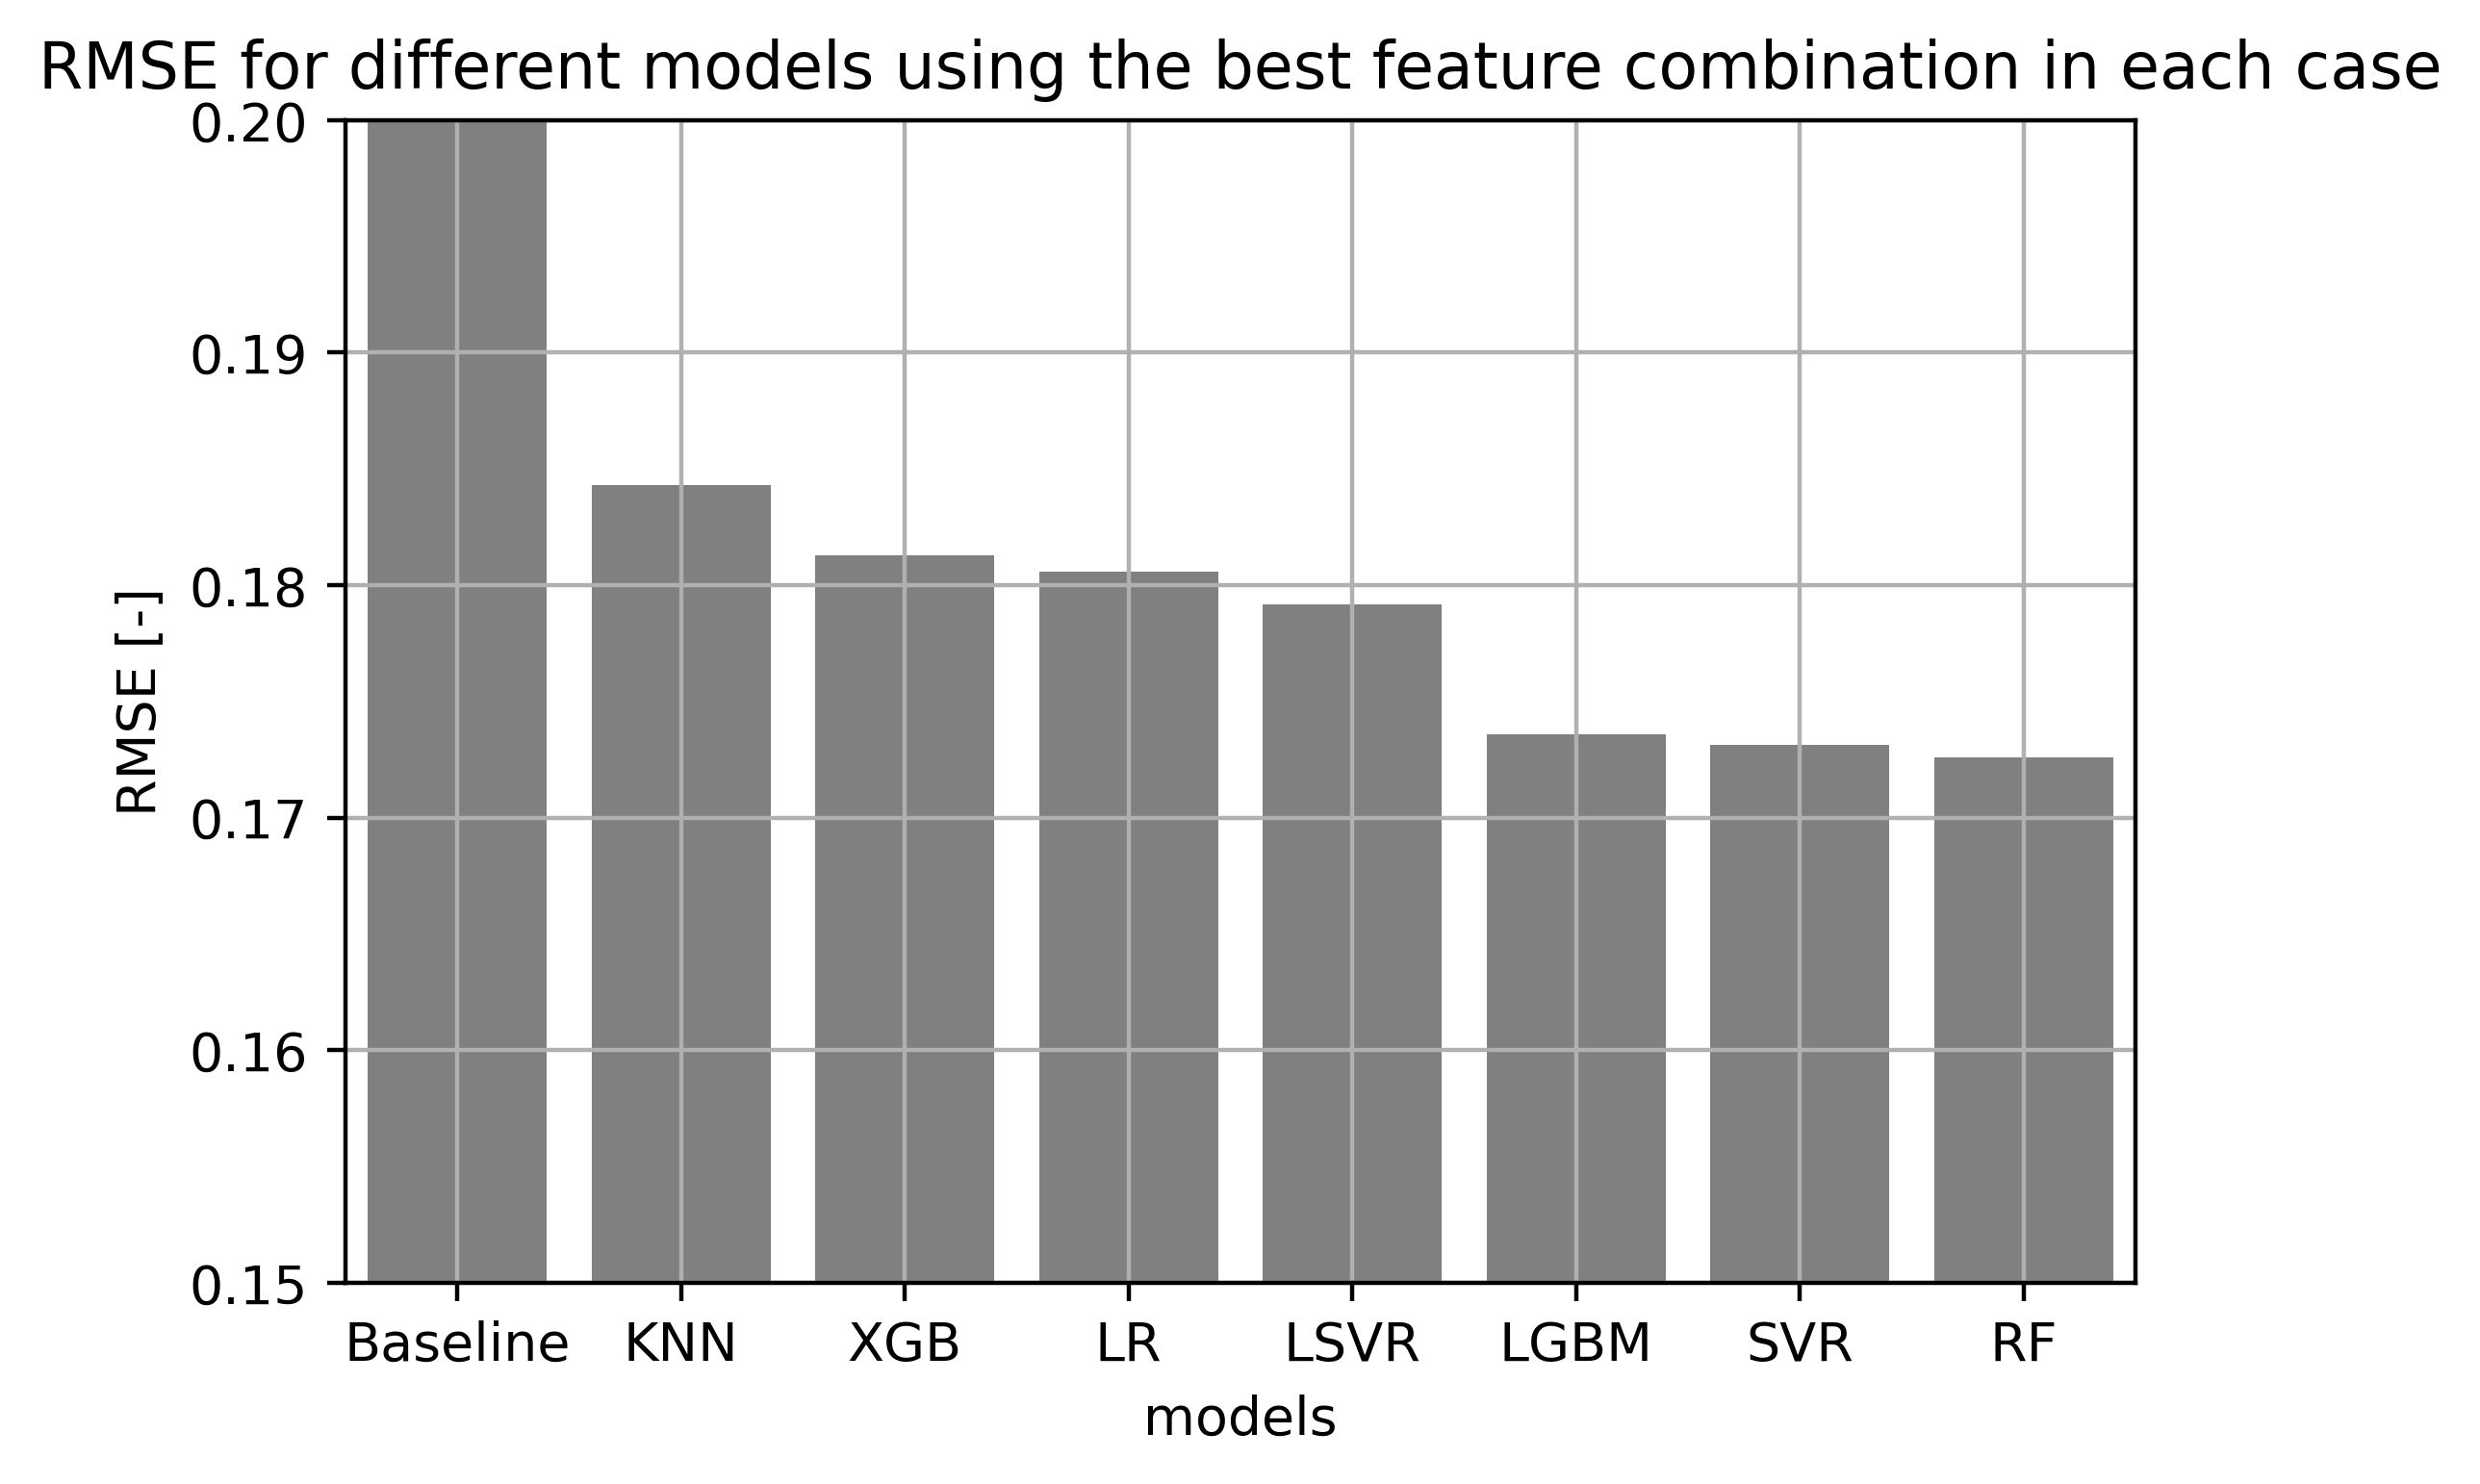

In [29]:
# ## plot zone-aggregated RMSE of different models (respectively best feature combination in TOTAL) against models
# models = ['Baseline','LR','KNN','SVR','LSVR', 'LGBM', 'XGB', 'RF']
# finalresult = pd.DataFrame(index=models, columns = ['score'])
# for model in models:
#     if model == 'Baseline':
#         finalresult.loc[model] = scores[(scores.model==model) & (scores.zone=='TOTAL')].test_score.values
#     else:
#         bf = bestfeature(scores, model)
#         finalresult.loc[model] = scores[(scores.model==model) & (scores.features==bf) & (scores.zone=='TOTAL')].test_score.values

# finalresult = finalresult.sort_values(by='score', ascending=False)
# fontsize=10
# fig, ax = plt.subplots(dpi=400)
# sns.barplot(data = finalresult, x = finalresult.index, y = finalresult['score'], color = 'gray', ax=ax)
# ax.grid()
# ax.set_xlabel('models', fontsize=fontsize)
# ax.set_ylabel('RMSE [-]', fontsize=fontsize)
# ax.tick_params(axis='both', labelsize=fontsize) 
# ax.set_ylim([0.15,0.2])
# ax.set_title('RMSE for different models using the best feature combination in each case');

In [ ]:
# ## function to convert two dictionaries with same key to pandas dataframes and join them to one dataframe
# def dict_to_df(x, y, model, features, z=None):
    
#     x = pd.DataFrame.from_dict(x, orient='index', columns = ['train_score'])
#     y = pd.DataFrame.from_dict(y, orient='index', columns = ['test_score'])
#     y = y.join(x).round(4).rename_axis('zone').reset_index()

#     if z:
#         #z = pd.DataFrame.from_dict(z, orient='index', columns = ['bestparams']).reset_index()
#         #list(z.values())
#         #y = y.join(z['bestparams'])
#         y[['model', 'features']] = [model, features]  
#         z = [x.get_params() for x in z.values()] 
#         z.append(np.nan)
#         y['bestparams'] = z

#     else:
#         y[['model', 'features', 'bestparams']] = [model, features, np.nan] 

#     return y

## get best feature combination with respect to zone-aggregated RMSE-values
# def bestfeature(scores, model, zone='TOTAL'):
#     return scores[(scores.model==model) & (scores.zone==zone)].groupby('features').min()['test_score'].sort_values().index[0]